# Querying the Genesis database

This notebook shows how to retrieve a single model run from the genesis database.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.stats

from matplotlib import animation
from IPython.display import HTML

plt.rcParams['axes.formatter.min_exponent'] = 3

## Load the genesis database from an hdf5 file

In [2]:
hf= h5py.File('../genesis_all.hdf5','r')
print(hf.attrs['info'])

Genesis database


List all the model run sets

In [3]:
for setID, runs in hf.items():
    print (setID)

Gen-HM
Gen-I
Gen-IO
Gen-M-s10
Gen-M-s22
Gen-M-s50
Gen-O
Gen-O-p1
Gen-O-p2
Gen-O-s10
Gen-O-s22
Gen-O-s5
Gen-P
Gen-P-I
Gen-P-IO


List all the models within the `Gen-HM` run set

In [4]:
print (list(hf['Gen-HM'].keys()))

['run_01', 'run_02', 'run_03', 'run_04', 'run_05', 'run_06', 'run_07', 'run_08', 'run_09', 'run_10', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49', 'run_50']


let's pick a single run as an example for this notebook

In [5]:
example= hf['Gen-HM']['run_34']

## Read in and visualize the data

### Snapshots

The `snapshots` contains the properties of all particles in the simulation at certain times.

In [6]:
example['snapshots'].keys()

<KeysViewHDF5 ['Omega', 'anomaly', 'ecc', 'id', 'inc', 'mass', 'omega', 'sma', 't']>

What each key means

In [7]:
for key in example['snapshots'].keys():
    print ('{}\t: {}'.format(key, hf.attrs[key]))

Omega	: Longitude of Ascending Node
anomaly	: Mean Anomaly at Epoch
ecc	: Eccentricity
id	: Particle Identifier
inc	: Inclination [degree]
mass	: Particle Mass [M_earth]
omega	: Argument of Periapsis
sma	: Semi-major Axis [au]
t	: Time [Myr]


Plot the time evolution of semi-maor axis

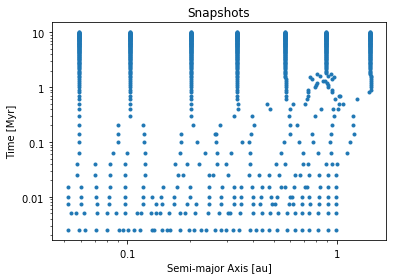

In [8]:
sma= example['snapshots']['sma'][()] # [()] is to extract to numpy arrays
time= example['snapshots']['t'][()]

plt.title('Snapshots')
plt.xlabel('Semi-major Axis [au]')
plt.ylabel('Time [Myr]')

plt.loglog(sma, time, '.')
plt.show()

The inclination and eccentricity evolution

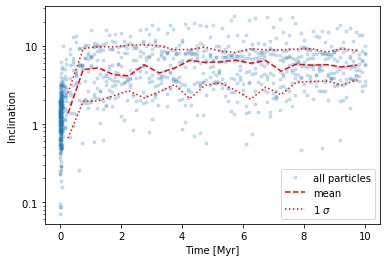

In [9]:
inc= example['snapshots']['inc'][()]

plt.xlabel('Time [Myr]')
plt.ylabel('Inclination')

#plt.loglog(time,inc, '.', alpha=0.2)
plt.semilogy(time,inc, '.', alpha=0.2, label='all particles')

# 1 sigma range
tgrid= np.unique(time)
time_bins= np.linspace(tgrid[0], tgrid[-1], 21)
time_center= 0.5*(time_bins[:-1]+time_bins[1:])

median, _, _ = scipy.stats.binned_statistic(time, inc, bins= time_bins, statistic='median')
sigma_pos, _, _ = scipy.stats.binned_statistic(time, inc, bins= time_bins,
                                        statistic=lambda x: np.percentile(x, 84) )
sigma_neg, _, _= scipy.stats.binned_statistic(time, inc, bins= time_bins,
                                        statistic=lambda x: np.percentile(x, 16) )

plt.plot(time_center, median, 'r--', label='mean')
plt.plot(time_center, sigma_pos, 'r:', label='1 $\\sigma$')
plt.plot(time_center, sigma_neg, 'r:')

plt.legend()
plt.show()

Show the initial conditions (t=0) and final snapshot

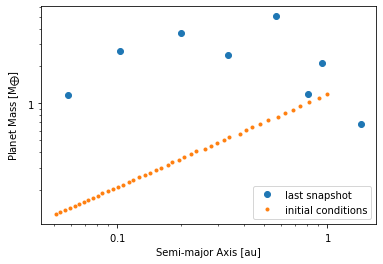

In [10]:
t0= time == time[0]
t1= time == time[-1]

mass= example['snapshots']['mass'][()]

plt.xlabel('Semi-major Axis [au]')
plt.ylabel('Planet Mass [M$_\\bigoplus$]')

plt.loglog(sma[t1], mass[t1], 'o', label='last snapshot')
plt.loglog(sma[t0], mass[t0], '.', label='initial conditions')
plt.legend()

Show the orbits (with rebound)

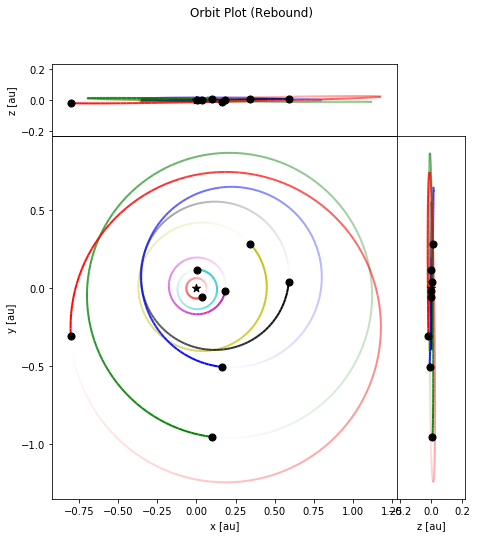

In [11]:
try:
    import rebound
    
    sim = rebound.Simulation()
    sim.add(m=1) # star

    # only "planets"
    ID= example['snapshots']['id'][()]
    
    for p_ID in ID[t1]:
        include= ((ID==p_ID)&(time==t1))
        #print (include)
        sim.add(m=example['snapshots']['mass'][()][include][0], 
                a=example['snapshots']['sma'][()][include][0], 
                inc=example['snapshots']['inc'][()][include][0]*(np.pi/180), 
                e=example['snapshots']['ecc'][()][include][0], 
                Omega=example['snapshots']['Omega'][()][include][0], 
                omega=example['snapshots']['omega'][()][include][0], 
                M=example['snapshots']['anomaly'][()][include][0])

    f, ax, ax_top, ax_bottom= rebound.OrbitPlot(sim, slices=0.2, color=True, lw=2,unitlabel='[au]')

    plt.suptitle('Orbit Plot (Rebound)')
    #plt.savefig(self.plot_dir+'orbit-final', dpi=150)
    plt.show()
    plt.close()
        
except ImportError:
    print ('Rebound not found')

### Collisions

The `collisions` contain which particles collided and merged and at what time. 

In [12]:
print(example['collisions'].attrs['info'])

particle i collided with particle j at time t


Let's visualize the collisions

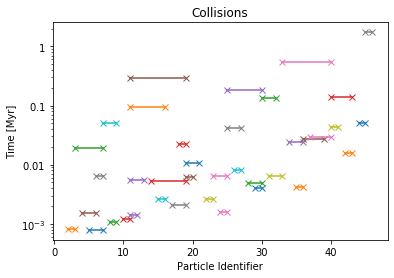

In [13]:
particle_i= example['collisions']['particle_i'][()]
particle_j= example['collisions']['particle_j'][()]
collision_time= example['collisions']['collision_time'][()]

plt.title('Collisions')
plt.xlabel('Particle Identifier')
plt.ylabel('Time [Myr]')

plt.semilogy()
for i,j,t in zip(particle_i, particle_j, collision_time):
    plt.plot([i,j],[t,t], 'x-')

### Planets and Building Blocks

The `planets` contain a list of particles that ended up in each planet.

In [14]:
print(example['planets'].attrs['info'])

planets and their building blocks


Print the building blocks for each planet

In [15]:
for key, planet in example['planets'].items():
    print ('planet {} consists of building blocks:\n  {}\n'.format(
        planet['id'][()], planet['bb'][()]))

planet 19 consists of building blocks:
  [10 11 12 13 14 15 16 17 18 19 20 21]

planet 25 consists of building blocks:
  [22 23 24 25 26 27 28 29 30 32]

planet 36 consists of building blocks:
  [34 35 36 39]

planet 40 consists of building blocks:
  [31 33 37 40 41 42 43]

planet 45 consists of building blocks:
  [44 45 46]

planet 7 consists of building blocks:
  [2 3 4 5 6 7 8 9]



The properties of the planets and of the building blocks can be extracted from the snapshots

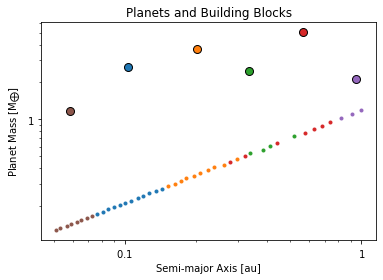

In [16]:
ID= example['snapshots']['id'][()]

plt.title('Planets and Building Blocks')
plt.xlabel('Semi-major Axis [au]')
plt.ylabel('Planet Mass [M$_\\bigoplus$]')
plt.loglog()

for planet in example['planets'].values():
    ip= ID == planet['id'][()]
    ibb= np.isin(ID, planet['bb'][()])
    
    pl= plt.loglog(sma[t1&ip], mass[t1&ip], 'o', ms=8, mec='k', zorder=10) # planet
    plt.loglog(sma[t0&ibb], mass[t0&ibb], '.', color=pl[0].get_color()) # bb w/ same color


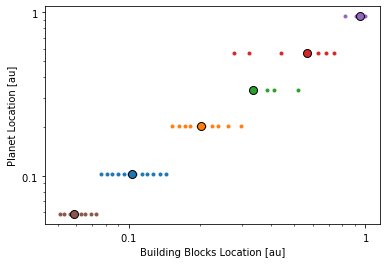

In [17]:
plt.xlabel('Building Blocks Location [au]')
plt.ylabel('Planet Location [au]')
#plt.xlim(0.05,3)
#plt.ylim(0.05,3)

plt.loglog()
    
for planet in example['planets'].values():
    ip= ID == planet['id'][()]
    ibb= np.isin(ID, planet['bb'][()])
    
    sma_planet= sma[t1&ip]
    sma_bb= sma[t0&ibb]
    
    pl= plt.plot(sma_planet, sma_planet, 'o', ms=8, mec='k', zorder=10) # planet
    plt.plot(sma_bb, [sma_planet]*len(sma_bb), '.', 
             color=pl[0].get_color())

Calculate the feeding zone of a planet (let's pick the 2nd one)

In [18]:
planets_string= list(example['planets'].keys())
planet= example['planets/{}'.format(planets_string[1])]

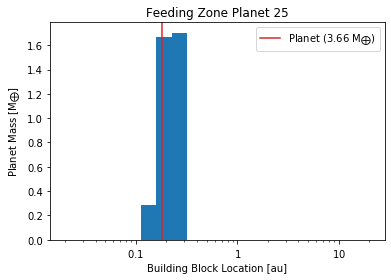

In [19]:
#plt.xlim(0.02,2)
#plt.ylim(0,3)

ip= np.isin(ID, planet['bb'][()])

plt.title('Feeding Zone Planet {}'.format(planet['id'][()]))
plt.xlabel('Building Block Location [au]')
plt.ylabel('Planet Mass [M$_\\bigoplus$]')

plt.semilogx()

plt.axvline(sma[t0&(ID==planet['id'])], color='C3', 
            label='Planet ({:.3g} M$_\\bigoplus$)'.format(mass[t1&(ID==planet['id'])][0]) )
plt.hist(sma[t0&ip], weights= mass[t0&ip], bins=np.geomspace(0.02,20, 21))
plt.legend()
plt.show()

Color-coded the snapshots particles that end up in the same planet

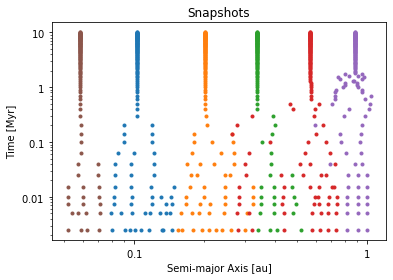

In [20]:
plt.title('Snapshots')
plt.xlabel('Semi-major Axis [au]')
plt.ylabel('Time [Myr]')
for planet in example['planets'].values():
    same_bb= np.isin(example['snapshots']['id'][()], planet['bb'][()])
    plt.loglog(sma[same_bb], time[same_bb], '.')

### Animations

We can also make animations of the simulation 

In [21]:
def mass_to_size(mass):
    mass=np.asarray(mass)
    s1, s2= 5,200
    m1, m2= 1,10
    size= s1 + (s2-s1)* np.log10(mass/m1) / np.log10(m2/m1)
    
    try:
        size[mass<m1]= s1
        size[mass>m2]= s2
    except TypeError:
        pass
    
    return size

In [22]:
f = plt.figure()
plt.semilogx()
plt.title('Genesis Example')
plt.xlim(0.03, 1.3)
plt.xlabel('Semi-Major Axis [au]')
plt.ylabel('Inclination [degree]')
#plt.ylabel('Eccentricity')


frames = []
for t in tgrid:
    it = time==t
    
    frame = plt.scatter(sma[it], inc[it],  marker='o', 
                         s=mass_to_size(mass[it]),
                        color='g', edgecolors='k',
                        animated=True)
    text= plt.text(0.95,0.95,'t= {:.1f} Myr'.format(t), 
                   animated=True, 
                   ha='right', va='top', 
                   transform=plt.gca().transAxes)
    frames.append([frame, text])
    
ani = animation.ArtistAnimation(f, frames, 
                                interval=50, blit=True, 
                                repeat=False)
plt.close()

# Show the animation
HTML(ani.to_html5_video())

Save the movie to disk
(click to view it [here)

In [23]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='EOS // Genesis'), bitrate=1800)
ani.save('genesis-animation.mp4', writer=writer)

## Goodbye

In [24]:
hf.close()